<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_08/instance_segmentation_using_a_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance segmentation using a pretrained model

Overtaken from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_image-segmentation.ipynb

We will use the Segment Anything Model (SAM):
- developed by Meta AI, Kirillov et al., Segment Anything, 2023, https://arxiv.org/abs/2304.02643
- trained on 11 million images and their segmentation masks, covering 1 billion object instances
- it is not limited to a predefined set of object classes -> segmenting by example (a point / more points/ target box)

In [ ]:

#!pip install keras keras-hub --upgrade -q


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

In [ ]:
print(os.environ.get("KERAS_BACKEND"))

jax


## Download the Segment Anything Model (SAM)


In [ ]:
import keras_hub

model = keras_hub.models.ImageSegmenter.from_preset("sam_huge_sa1b")
model.count_params()

641090864

### Prepare a test image

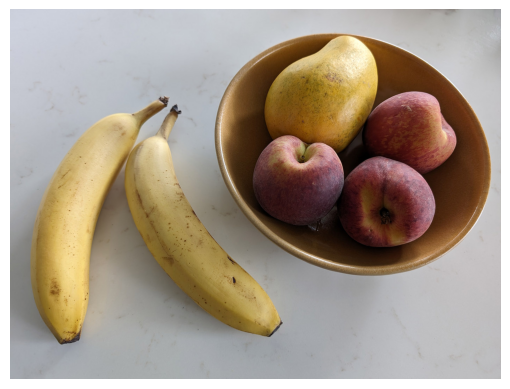

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np

path = keras.utils.get_file(
    origin="https://s3.amazonaws.com/keras.io/img/book/fruits.jpg"
)
pil_image = keras.utils.load_img(path)
image_array = keras.utils.img_to_array(pil_image)

plt.imshow(image_array.astype("uint8"))
plt.axis("off")
plt.show()

In [ ]:
from keras import ops

image_size = (1024, 1024)

def resize_and_pad(x):
    return ops.image.resize(x, image_size, pad_to_aspect_ratio=True)

image = resize_and_pad(image_array)

In [ ]:

import matplotlib.pyplot as plt
from keras import ops

def show_image(image, ax):
    ax.imshow(ops.convert_to_numpy(image).astype("uint8"))

def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w, _ = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(points, ax):
    x, y = points[:, 0], points[:, 1]
    ax.scatter(x, y, c="green", marker="*", s=375, ec="white", lw=1.25)

def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, ec="red", fc="none", lw=2))



### Prompting the model with a target point

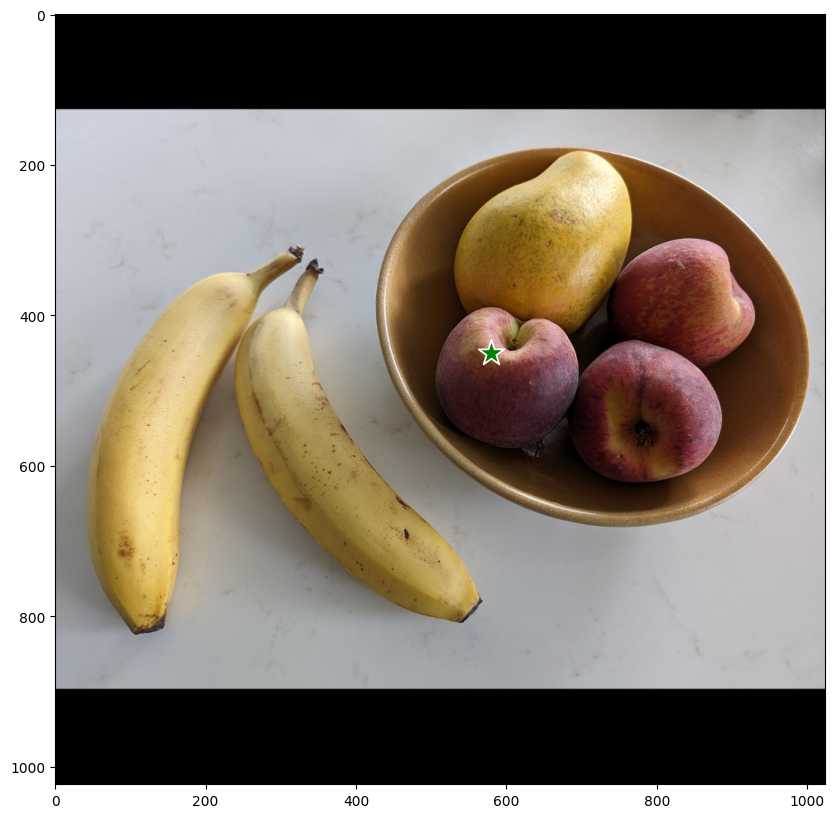

In [ ]:
import numpy as np

input_point = np.array([[580, 450]])
input_label = np.array([1]) # 1 ... foreground, 0 ... background

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_points(input_point, plt.gca())
plt.show()

- the input is a triple:
  - image
  - a point inside the object to mask
  - label (ground truth mask)

In [ ]:
outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "points": ops.expand_dims(input_point, axis=0),
        "labels": ops.expand_dims(input_label, axis=0),
    }
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 170s 170s/step


In [ ]:
outputs["masks"].shape # four 256x256 candidate masks, ranked by decreasing match quality

(1, 4, 256, 256)

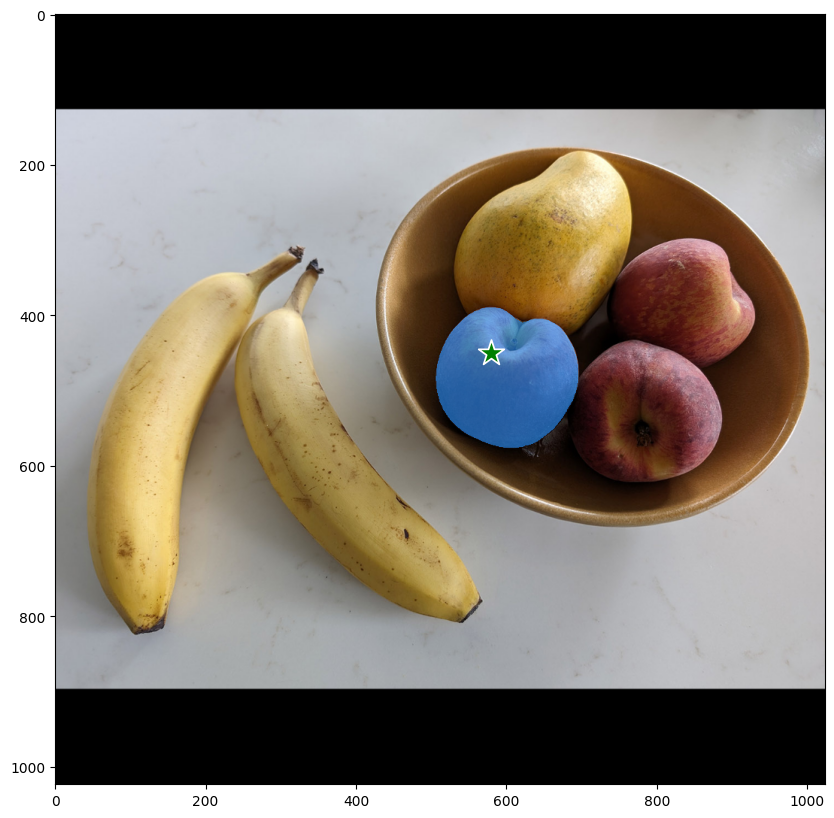

In [ ]:
def get_mask(sam_outputs, index=0):
    mask = sam_outputs["masks"][0][index]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize_and_pad(mask)
    return ops.convert_to_numpy(mask) > 0.0

mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 142s 142s/step


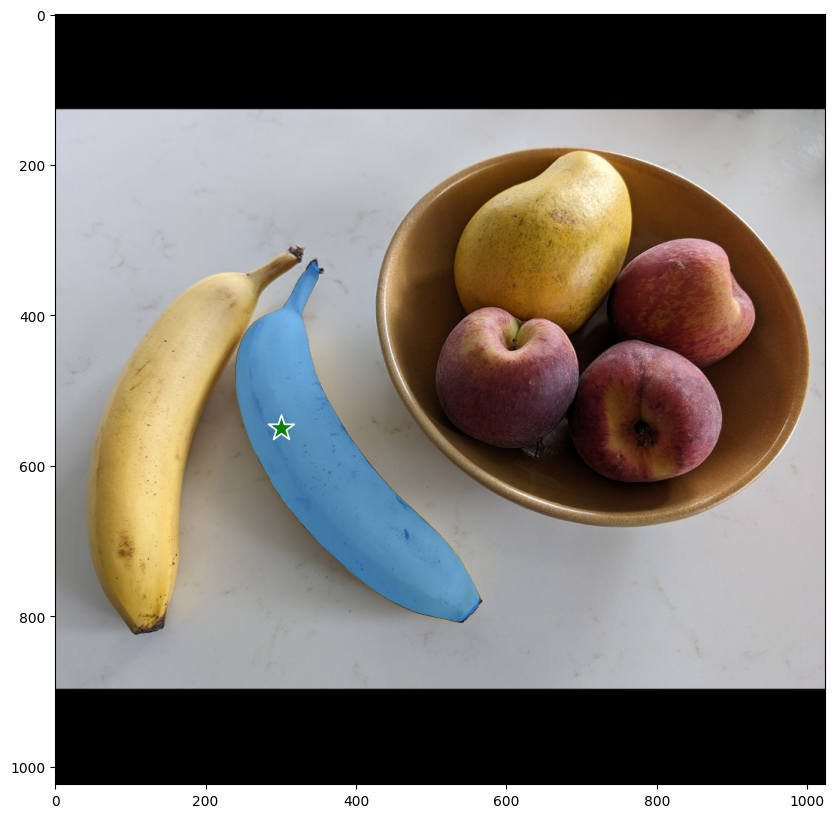

In [ ]:
input_point = np.array([[300, 550]])
input_label = np.array([1])

outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "points": ops.expand_dims(input_point, axis=0),
        "labels": ops.expand_dims(input_label, axis=0),
    }
)
mask = get_mask(outputs, index=0)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_points(input_point, plt.gca())
plt.show()

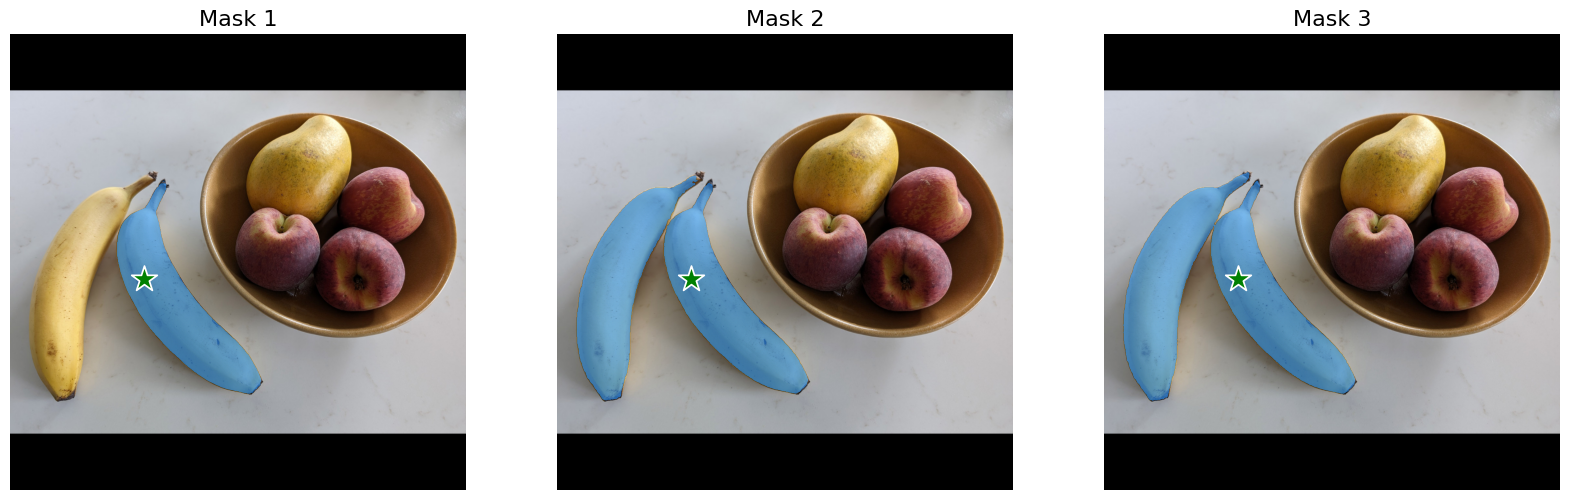

In [ ]:
# All mask candidates:
fig, axes = plt.subplots(1, 3, figsize=(20, 60))
masks = outputs["masks"][0][1:]
for i, mask in enumerate(masks):
    show_image(image, axes[i])
    show_points(input_point, axes[i])
    mask = get_mask(outputs, index=i + 1)
    show_mask(mask, axes[i])
    axes[i].set_title(f"Mask {i + 1}", fontsize=16)
    axes[i].axis("off")
plt.show()

### Prompting the model with a target box

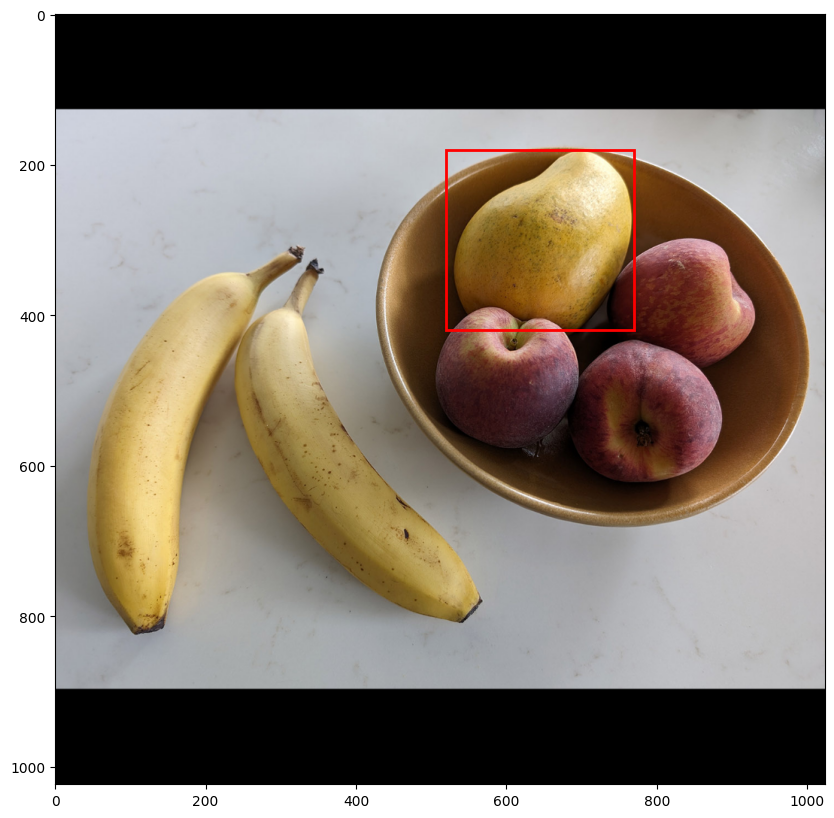

In [ ]:
input_box = np.array(
    [
        [520, 180], # top-left corner
        [770, 420], # bottom-right corner
    ]
)

plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_box(input_box, plt.gca())
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 158s 158s/step


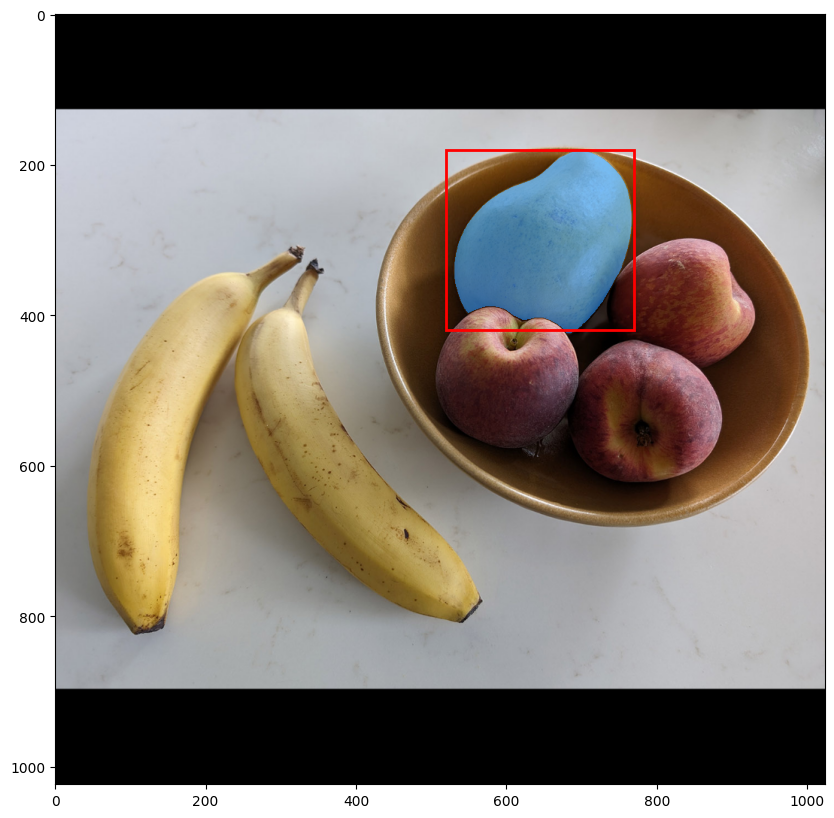

In [ ]:
outputs = model.predict(
    {
        "images": ops.expand_dims(image, axis=0),
        "boxes": ops.expand_dims(input_box, axis=(0, 1)),
    }
)
mask = get_mask(outputs, 0)
plt.figure(figsize=(10, 10))
show_image(image, plt.gca())
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.show()

Based on examples from François Chollet (MIT License):
https://github.com/fchollet/deep-learning-with-python-notebooks